# 第8章　さらにグラフィカルに調べよう
## 8.2 自己相関と偏自己相関

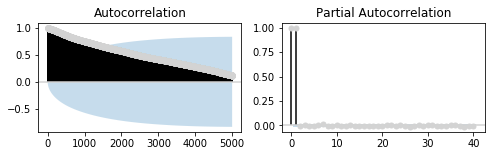

In [1]:
%matplotlib inline
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
n225 = web.DataReader("NIKKEI225", 'fred',"1949/5/16").dropna()
lnn225=np.log(n225)
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(1,2,1)
fig = sm.graphics.tsa.plot_acf(lnn225.squeeze(), lags=5000, color='lightgray',ax=ax1)
ax2 = fig.add_subplot(1,2,2)
fig = sm.graphics.tsa.plot_pacf(lnn225.squeeze(), lags=40,color='lightgray', ax=ax2)

In [2]:
import warnings
warnings.simplefilter('ignore') 
#ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. 
#forecasting.' ignored when e.g. forecasting.', ValueWarning)

arma_mod = sm.tsa.ARMA(lnn225,order=(1,0))
arma_res = arma_mod.fit(trend='c', disp=-1)
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:              NIKKEI225   No. Observations:                17645
Model:                     ARMA(1, 0)   Log Likelihood               52482.854
Method:                       css-mle   S.D. of innovations              0.012
Date:                Sun, 10 May 2020   AIC                        -104959.708
Time:                        14:44:41   BIC                        -104936.374
Sample:                             0   HQIC                       -104952.027
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.6554      2.120      3.611      0.000       3.500      11.811
ar.L1.NIKKEI225     1.0000   2.01e-05   4.96e+04      0.000       1.000       1.000
                                

C:\Users\moriya\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0, 0.5, '$\\hat{z_t}$')

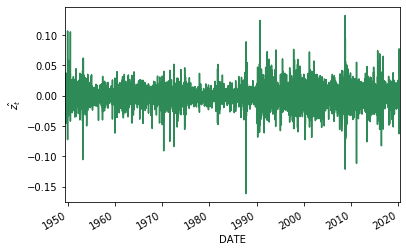

In [3]:
arma_res.resid.iloc[1:].plot(figsize=(6,4),color='seagreen')
plt.ylabel('$\hat{z_t}$')

In [4]:
from statsmodels.tsa import stattools
acf,q,pvalue = stattools.acf(arma_res.resid,nlags=5,qstat=True,fft=False)
pacf,confint = stattools.pacf(arma_res.resid,nlags=5,alpha=0.05)
print("自己相関係数：",acf)
print("p値:",pvalue)
print("偏自己相関:",pacf)
print("95%信頼区間:",confint)

自己相関係数： [ 1.00000000e+00  9.16021310e-03 -6.38845182e-04  5.15786192e-03
  6.33372451e-03 -6.50185548e-03]
p値: [0.22364393 0.47520027 0.58125547 0.61523354 0.63675785]
偏自己相関: [ 1.00000000e+00  9.16073226e-03 -7.22897282e-04  5.17165516e-03
  6.24067494e-03 -6.61253945e-03]
95%信頼区間: [[ 1.          1.        ]
 [-0.0055942   0.02391567]
 [-0.01547783  0.01403204]
 [-0.00958328  0.01992659]
 [-0.00851426  0.02099561]
 [-0.02136747  0.00814239]]


In [5]:
from statsmodels.tsa.stattools import adfuller
p=adfuller(arma_res.resid,regression='nc')[1] #[1]はp値の検定結果
p1=adfuller(arma_res.resid,regression='c')[1] #[1]はp値の検定結果
print("ドリフト無しランダムウォーク p値:",p)
print("ドリフト付きランダムウォーク p値:",p1)


ドリフト無しランダムウォーク p値: 0.0
ドリフト付きランダムウォーク p値: 0.0


In [6]:
from scipy.stats import t
resid=arma_res.resid.iloc[1:]
m=resid.mean()
v=resid.std()
resid_max=pd.Series.rolling(arma_res.resid,window=250).mean().max()
resid_min=pd.Series.rolling(arma_res.resid,window=250).mean().min()
print("平均:              %2.5f"%m,"標準偏差：          %2.4f"%v)
print("250日平均の最大値: %2.5f"%resid_max,"250日平均の最小値: %2.5f"%resid_min)
print("250日平均の95%の信頼区間: ",(t.interval(alpha=0.95, df=250, loc=0, scale=v)))


平均:              0.00028 標準偏差：          0.0124
250日平均の最大値: 0.00363 250日平均の最小値: -0.01236
250日平均の95%の信頼区間:  (-0.024329455215772042, 0.024329455215772042)


Text(0, 0.5, '$\\hat{z_t}$')

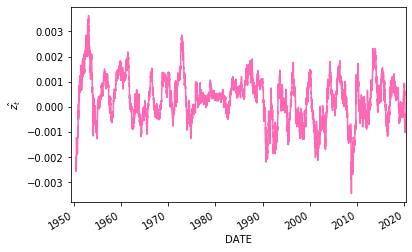

In [7]:
pd.Series.rolling(arma_res.resid.iloc[1:],250).mean().plot(figsize=(6,4),color='hotpink')
plt.ylabel('$\hat{z_t}$')

In [8]:
from scipy.stats import chi2
resid=arma_res.resid.iloc[1:]
m=resid.mean()
v=resid.std()
resid_max=pd.Series.rolling(arma_res.resid,window=250).std().max()
resid_min=pd.Series.rolling(arma_res.resid,window=250).std().min()
print("平均:                 %2.5f"%m,"        標準偏差：    %2.5f"%v)
print("250日標準偏差の最大値:%2.5f"%resid_max,"250日標準偏差の最小値:%2.5f"%resid_min)

cint1,cint2=chi2.interval(alpha=(0.95), df=249)

print("250日標準偏差の95pctの信頼区間:%2.4f"%(np.sqrt(cint1/249)*v),)
print("<= \sigma <=%2.4f"%(np.sqrt(cint2/249)*v))


平均:                 0.00028         標準偏差：    0.01235
250日標準偏差の最大値:0.15814 250日標準偏差の最小値:0.00417
250日標準偏差の95pctの信頼区間:0.0113
<= \sigma <=0.0134


Text(0, 0.5, '$std$')

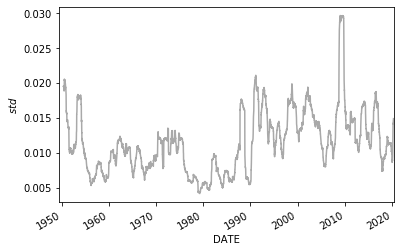

In [9]:
pd.Series.rolling(arma_res.resid.iloc[1:],250).std().plot(figsize=(6,4),color='darkgray')
plt.ylabel('$std$')

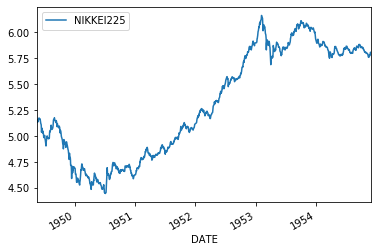

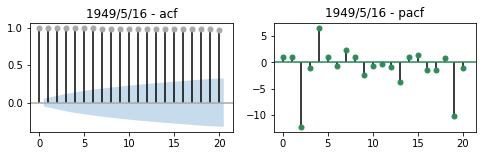

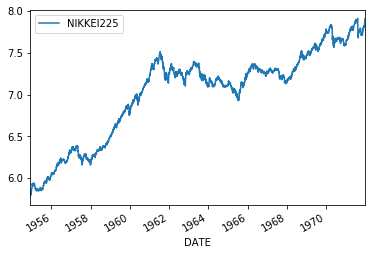

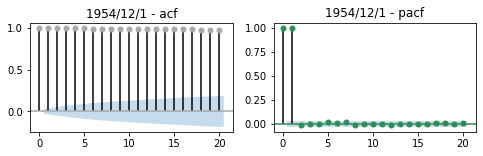

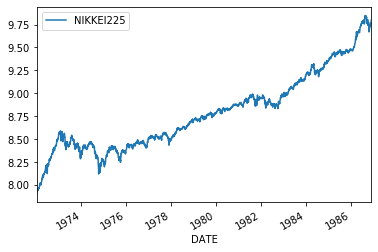

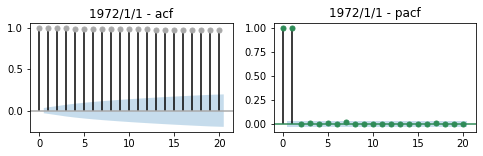

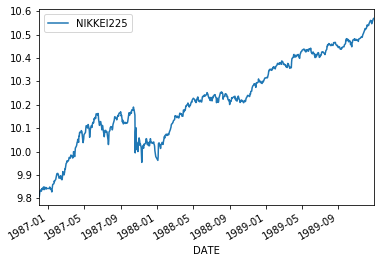

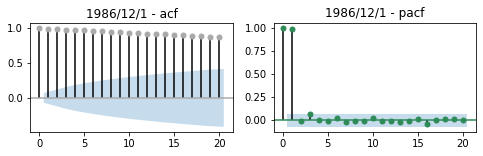

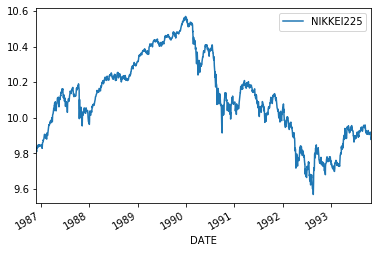

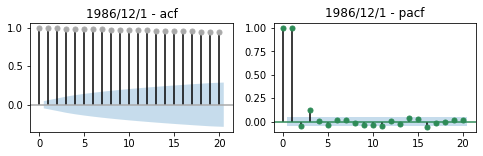

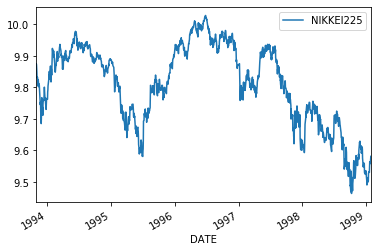

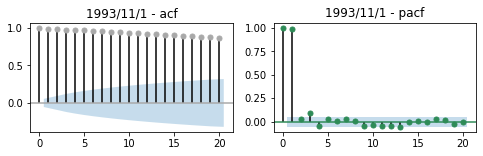

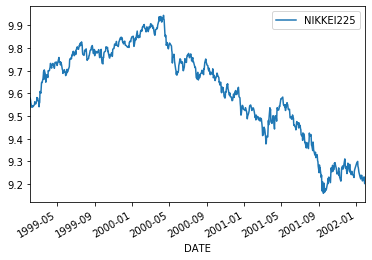

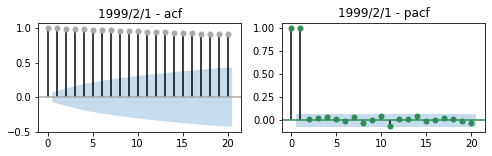

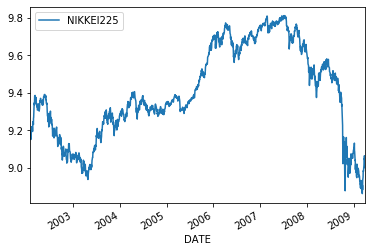

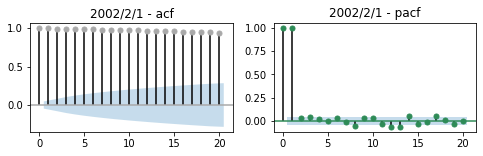

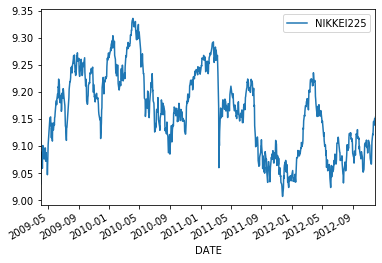

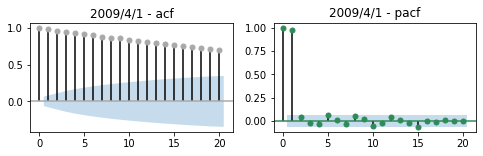

In [12]:
bcs=["1949/5/16","1954/12/1","1972/1/1","1986/12/1","1986/12/1",
     "1993/11/1","1999/2/1","2002/2/1","2009/4/1"]
bce=["1954/11/30","1971/12/31","1986/11/30","1989/12/31","1993/10/30",
     "1999/1/31","2002/1/31","2009/3/31","2012/11/30"]
for i in range(len(bcs)):
    y=lnn225.loc[bcs[i]:bce[i]].dropna()
    y.plot()
    fig = plt.figure(figsize=(8,2))
    ax1 = fig.add_subplot(1,2,1)
    fig = sm.graphics.tsa.plot_acf(y.values.squeeze(), lags=20, ax=ax1,color='darkgray')
    plt.title(bcs[i]+' - acf')
    ax2 = fig.add_subplot(1,2,2)
    fig = sm.graphics.tsa.plot_pacf(y.values.squeeze(), lags=20, ax=ax2,color='seagreen')
    plt.title(bcs[i]+' - pacf')

In [11]:
warnings.simplefilter('ignore') 
# ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. 
# forecasting.' ignored when e.g. forecasting.', ValueWarning)

for i in range(len(bcs)):
    y=lnn225.loc[bcs[i]:bce[i]].dropna()
    arma_mod = sm.tsa.ARMA(y,order=(1,0))
    arma_res = arma_mod.fit(trend='c', disp=-1)
    print(bcs[i],arma_res.arparams,arma_res.resid.std())

1949/5/16 [0.99941744] 0.016123083782795682
1954/12/1 [0.99995716] 0.018856497363001327
1972/1/1 [0.99995968] 0.017363176077824848
1986/12/1 [0.99941777] 0.01780660506720022
1986/12/1 [0.99803652] 0.015223323127160173
1993/11/1 [0.9942536] 0.014658340097467927
1999/2/1 [0.99766284] 0.015757473199886497
2002/2/1 [0.99795656] 0.01669858099355767
2009/4/1 [0.98415868] 0.013948779346039527
